In [20]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
import glob

In [21]:
nc_files = sorted(glob.glob("C:/Users\locfa_v05v5qi/Documents/escadas_termohalinas/raw/Dataset/**/*.nc", recursive=True))

In [22]:
#RECORTE REGIONAL

def subset_region(ds):

    # Ajustar longitudes se estiverem em 0–360
    if float(ds.lon.max()) > 180:
        ds = ds.assign_coords(
            lon=((ds.lon + 180) % 360) - 180
        )

    mask = (
        (ds.lat <= 10) & (ds.lat >= -60) &
        (ds.lon >= -50) & (ds.lon <= -10)
    )

    if "Nobs" in ds.dims:
        ds = ds.isel(Nobs=mask)

    return ds


#DETECÇÃO DE STAIRCASE (já usando máscaras do dataset)

def detect_staircases(ds):

    profile_dim = ds.lat.dims[0]
    n_profiles = ds.sizes[profile_dim]

    staircase_sf = np.zeros(n_profiles, dtype=bool)
    staircase_dc = np.zeros(n_profiles, dtype=bool)

    for i in range(n_profiles):

        ml_mask_sf = ds.mask_ml_sf_layer.isel({profile_dim: i}) > 0
        ml_mask_dc = ds.mask_ml_dc_layer.isel({profile_dim: i}) > 0

        if np.any(ml_mask_sf):
            staircase_sf[i] = True

        if np.any(ml_mask_dc):
            staircase_dc[i] = True

    ds["staircase_sf"] = (profile_dim, staircase_sf)
    ds["staircase_dc"] = (profile_dim, staircase_dc)

    return ds

In [23]:
points = {
    "lon": [],
    "lat": [],
    "mean_depth": [],
    "mean_thickness": []
}

for fname in nc_files:
    try:
        ds = xr.open_dataset(fname)
        ds = subset_region(ds)

        nobs = ds.sizes.get("Nobs", 0)

        if nobs == 0:
            ds.close()
            continue

        for i in range(nobs):

            lat = float(ds.lat[i])
            lon = float(ds.lon[i])

            sf = ds.mask_ml_sf_layer[i, :].values
            dc = ds.mask_ml_dc_layer[i, :].values

            # Índices com staircase (SF ou DC)
            idx = np.where((sf > 0) | (dc > 0))[0]

            # Se não houver staircase no perfil → pula
            if len(idx) == 0:
                continue

            # Calcula médias apenas das camadas com staircase
            mean_depth = np.nanmean(ds.ml_p[i, idx].values)
            mean_thickness = np.nanmean(ds.ml_h[i, idx].values)

            points["lon"].append(lon)
            points["lat"].append(lat)
            points["mean_depth"].append(mean_depth)
            points["mean_thickness"].append(mean_thickness)

        ds.close()

    except Exception as e:
        print("Erro em", fname, "->", e)


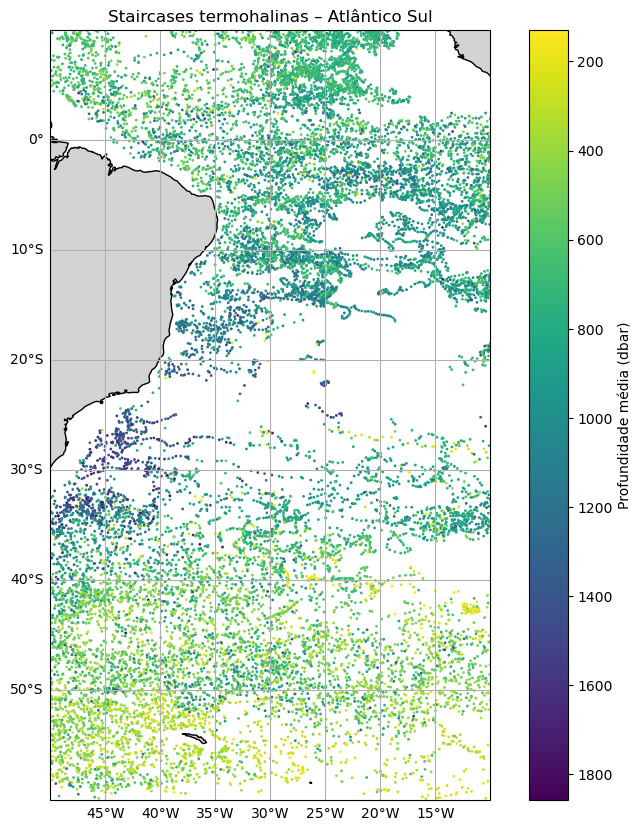

In [24]:
for k in points:
    points[k] = np.array(points[k])

# criar figura
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# limites do Atlântico Sul
ax.set_extent([-50, -10, -60, 10], crs=ccrs.PlateCarree())

# mapa base
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.COASTLINE)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# plotar pontos
sc = ax.scatter(
    points["lon"],
    points["lat"],
    c=points["mean_depth"],          # coloração por profundidade
    s=1,                         # MUITO IMPORTANTE: ponto pequeno
    cmap="viridis_r",
    transform=ccrs.PlateCarree()
)

# barra de cores
cb = plt.colorbar(sc, ax=ax, label="Profundidade média (dbar)")
cb.ax.invert_yaxis()

plt.title("Staircases termohalinas – Atlântico Sul")
plt.show()

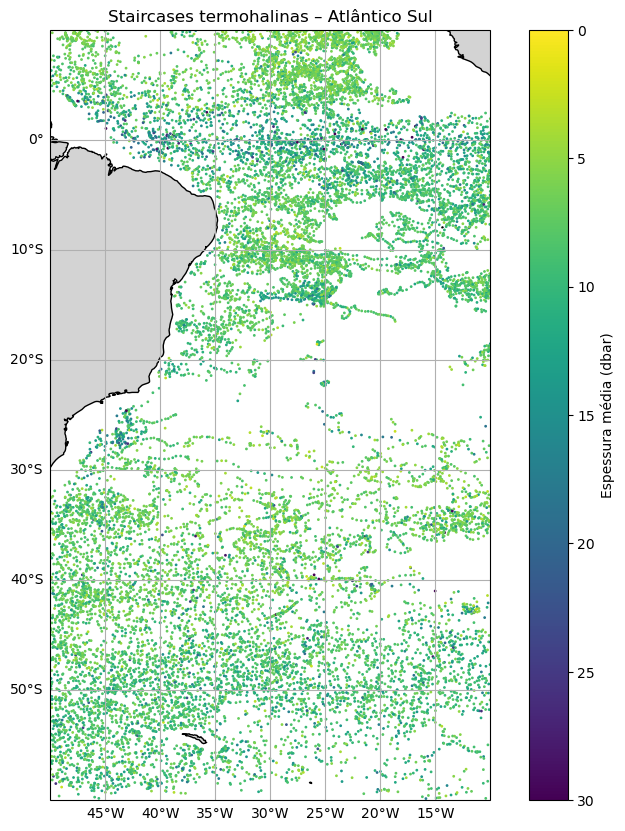

In [25]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# limites do Atlântico Sul
ax.set_extent([-50, -10, -60, 10], crs=ccrs.PlateCarree())

# mapa base
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.COASTLINE)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# plotar pontos
sc = ax.scatter(
    points["lon"],
    points["lat"],
    c=points["mean_thickness"],          # coloração por profundidade
    s=1,                         # MUITO IMPORTANTE: ponto pequeno
    cmap="viridis_r",
    vmin= 0,
    vmax = 30,
    transform=ccrs.PlateCarree()
)
# barra de cores
cb = plt.colorbar(sc, ax=ax, label="Espessura média (dbar)")
cb.ax.invert_yaxis()

plt.title("Staircases termohalinas – Atlântico Sul")
plt.show()